In [81]:
# This script applies EPSC thresholding to the time series data
import numpy as np
import scipy.stats as stats
import pyabf
import matplotlib.pyplot as plt

In [100]:
def epsc_threshold(data, thres=-5, rearm=None, min_length=0):
    """
    detect ESPCs via thresholding

    return thresholded
    """
    #get points where data crosses the threshold
    thresholded = np.argwhere(data < thres).flatten()
    #count the first instances of each continous threshold
    if rearm is None:
        diff = np.diff(thresholded, prepend=0)
        first_instances = np.argwhere(diff > 1).flatten()
        first_instances = thresholded[first_instances]
        
    elif rearm is not None:
        diff = np.diff(thresholded, prepend=0)
        first_instances = np.argwhere(diff > 1).flatten()
        first_instances = thresholded[first_instances]
        first_instances_adj = []
        last_point = -1
        for i in range(len(first_instances)):
            point = first_instances[i]
            if point < last_point:
                continue
            #get the next point in the data where the data dips below rearm
            next_point = np.argwhere(data[point:] > rearm).flatten()
            if len(next_point) == 0:
                first_instances_adj.append(len(data) - 1)
                continue
            else:
                next_point = next_point[0] + point
            #is it min number of samples apart?
            if next_point - last_point > min_length:
                last_point = next_point
                first_instances_adj.append(point)
            #skip points that are too close together
            if point - last_point < min_length:
                continue
        first_instances = np.array(first_instances_adj)
    else:
        first_instances = np.argwhere(diff > 1).flatten()
        first_instances = thresholded[first_instances]

    return thresholded, first_instances

In [142]:
FILE_PATH = "Z:\\Molsrv\\Julia\\Data\\Opto\\Opto Perifornical for Grant_2025\\ALL FILES\\2025_08_06_0023.abf"
baseline = (1.0, 1.01)
stim_time = (1.047, 1.057)

def plot_file(abf, first_instances):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
    factor_ = 30
    for x in abf.sweepList:
        abf.setSweep(x)
        first_inst_temp = first_instances[x]
        data = abf.sweepY
            #baseline the data by takeing the slope of the sweep
        baseline_slope = np.polyfit(abf.sweepX, data, 1)
        baseline_intercept = baseline_slope[1]
        data = data - (baseline_slope[0] * abf.sweepX + baseline_intercept)

        if factor_ is not None:
            factor = x*factor_
        elif factor_ is None:
            factor = 0.0
            print(factor_)

        ax[0].plot(abf.sweepX, data+factor, label='Data', c='k')
        ax[0].plot(abf.sweepX[first_inst_temp], data[first_inst_temp]+factor, 'ro', label='Thresholded')
        ax[0].axhline(y=-5+factor, color='r', linestyle='--', label='Threshold')
        ax[0].axhline(y=-2+factor, color='g', linestyle='--', label='Rearm')
        ax[0].set_xlim(baseline[0] - 0.01, baseline[1] + 0.01)
        ax[1].plot(abf.sweepX, data+factor, label='Data', c='k')
        ax[1].plot(abf.sweepX[first_inst_temp], data[first_inst_temp]+factor, 'ro', label='Thresholded')
        ax[1].axhline(y=-5+factor, color='r', linestyle='--', label='Threshold')
        ax[1].axhline(y=-2+factor, color='g', linestyle='--', label='Rearm')
        #plt.legend()
        ax[1].set_xlim(stim_time[0] - 0.01, stim_time[1]+ 0.01)
    ax[1].axvline(x=stim_time[0], color='b', linestyle='--', label='Stim Start')
    ax[1].axvline(x=stim_time[1], color='b', linestyle='--', label='Stim End')
    ax[1].set_ylim(-100, (factor)+10)

    plt.show()


def process_file(file_path):

    abf = pyabf.ABF(file_path)

    sweep_first = []
    return_dict = {'pre_event_count':[], 'stim_event_count':[], 'threshold_idx':[]}
    for x in abf.sweepList:
        abf.setSweep(x)
        data = abf.sweepY

        #baseline the data by takeing the slope of the sweep
        baseline_slope = np.polyfit(abf.sweepX, data, 1)
        baseline_intercept = baseline_slope[1]
        data = data - (baseline_slope[0] * abf.sweepX + baseline_intercept)

        #try EPSC thresholding
        thresholded, first_instances = epsc_threshold(data, thres=-7, rearm=-2, min_length=100)
        sweep_first.append(first_instances if first_instances.size > 0 else None)

        #event thresholds
        event_times_sweep = abf.sweepX[first_instances]

        #get num events within baseline

        num_events_baseline = np.sum((event_times_sweep >= baseline[0]) & (event_times_sweep < baseline[1]))
        num_events_stim = np.sum((event_times_sweep >= stim_time[0]) & (event_times_sweep < stim_time[1]))
        return_dict['pre_event_count'].append(num_events_baseline)
        return_dict['stim_event_count'].append(num_events_stim)
        return_dict['threshold_idx'].append(first_instances)
    plot_file(abf, sweep_first)
    return return_dict


   Cell ID    Date Mouse ID Sex Condition Slice ID     Well#     Filled?  \
0  1_JS_01  250806    854-3   M      Ctrl      2-R        B2  Not filled   
1  1_JS_02  250806    854-3   M      Ctrl      2-R        B2  Not filled   
3  1_JS_04  250806    854-3   M      Ctrl      2-R        B2  Not filled   
4  1_JS_05  250806    854-2   M        KD      2-X  B 5 or 6  Not filled   
5  1_JS_06  250806    854-2   M        KD      3-L        C5  Not filled   

             Area Exerimenter  ...       PP (20 ms)          PP Link  \
0      PF-ventral          JS  ...  2025_08_06_0003  2025_08_06_0003   
1      PF-ventral          JS  ...  2025_08_06_0007  2025_08_06_0007   
3      PF-lateral          JS  ...  2025_08_06_0018  2025_08_06_0018   
4  PF-dorsomedial          JS  ...              NaN              NaN   
5       PF-medial          JS  ...              NaN              NaN   

       PS Check VC  PS CheckVC  Link PS Check IC PS Check IC Link 10 Hz Train  \
0  2025_08_06_0004   2025_08_

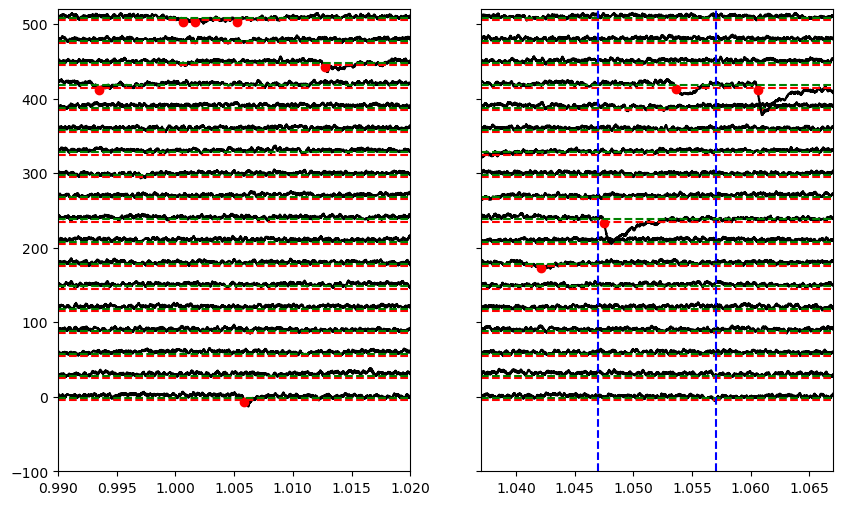

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0007.abf


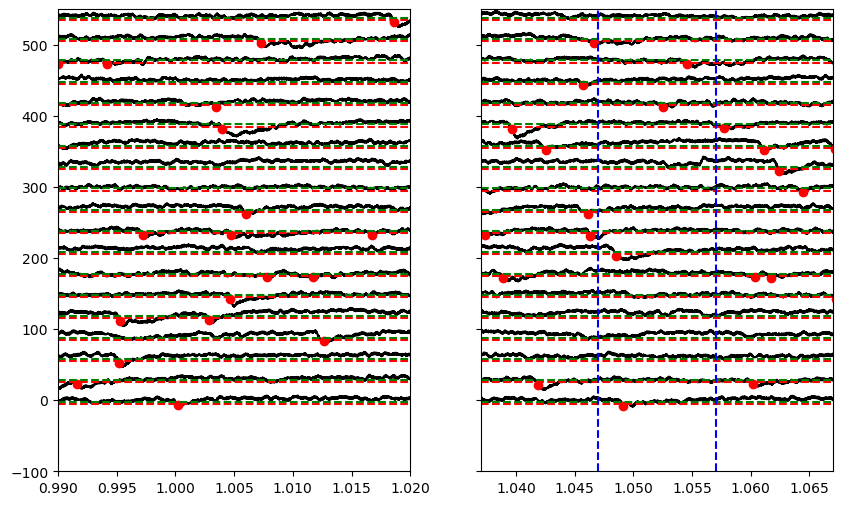

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0018.abf


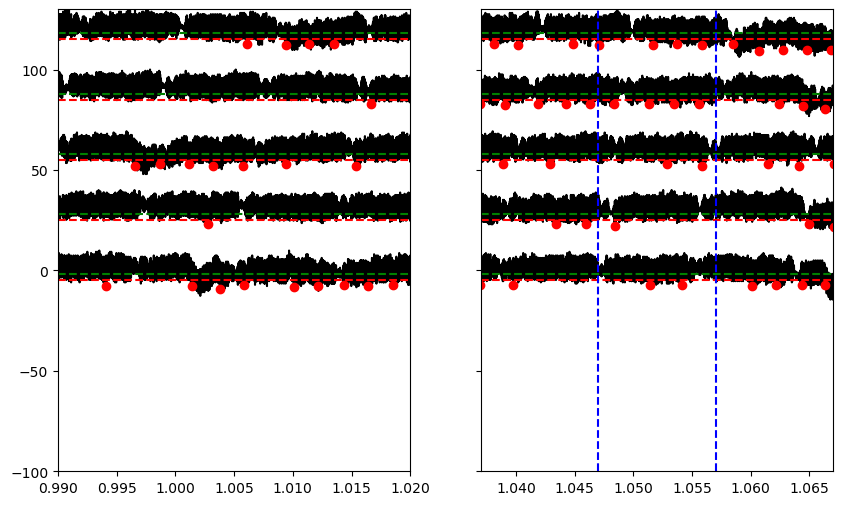

!!!! File not found: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\nan.abf !!!!
!!!! File not found: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\nan.abf !!!!
!!!! File not found: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\nan.abf !!!!
!!!! File not found: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\nan.abf !!!!
!!!! File not found: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\nan.abf !!!!
Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0054.abf


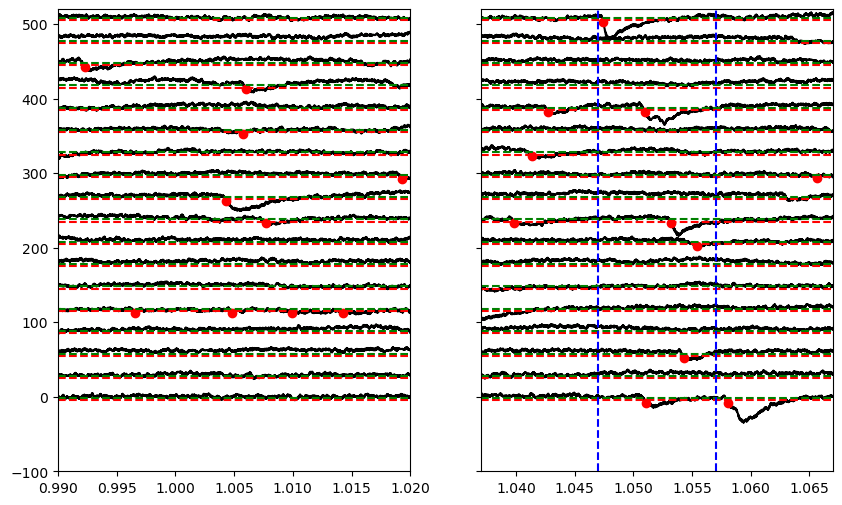

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0060.abf


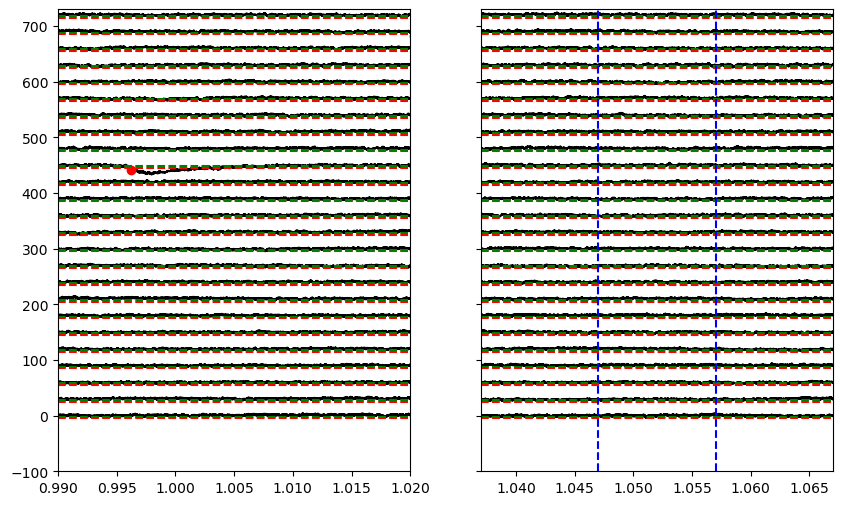

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0062.abf


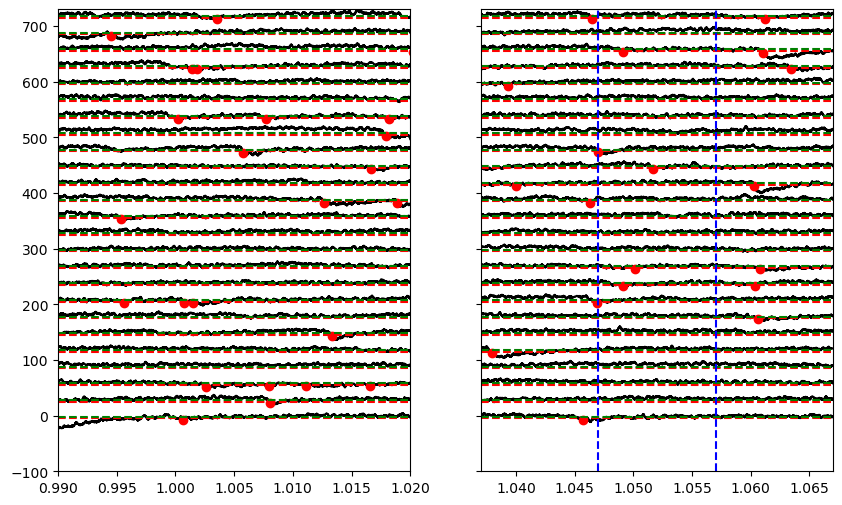

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0066.abf


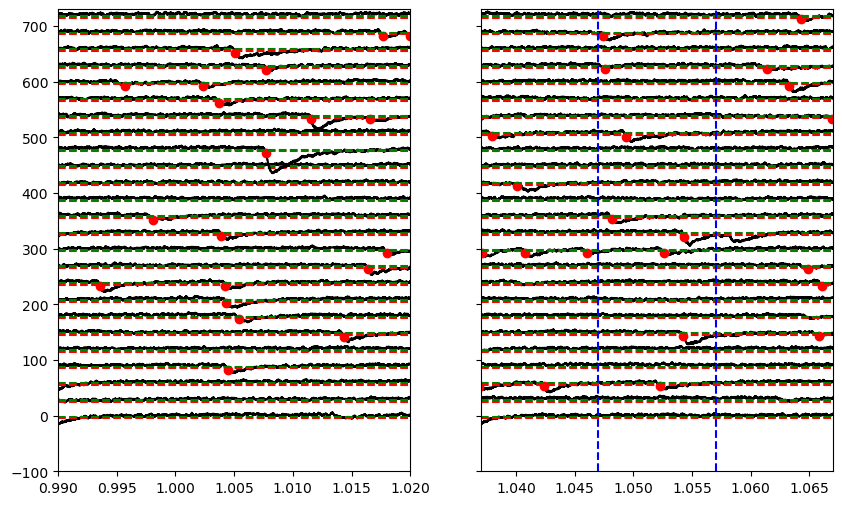

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0074.abf


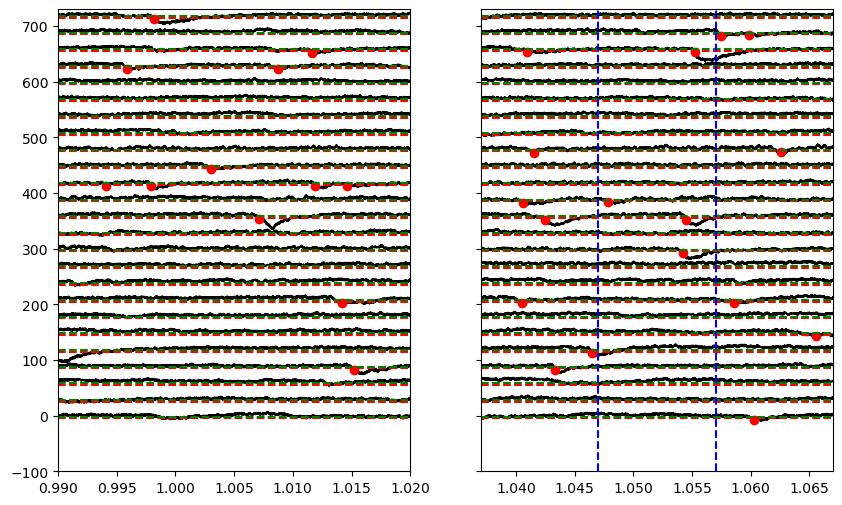

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0077.abf


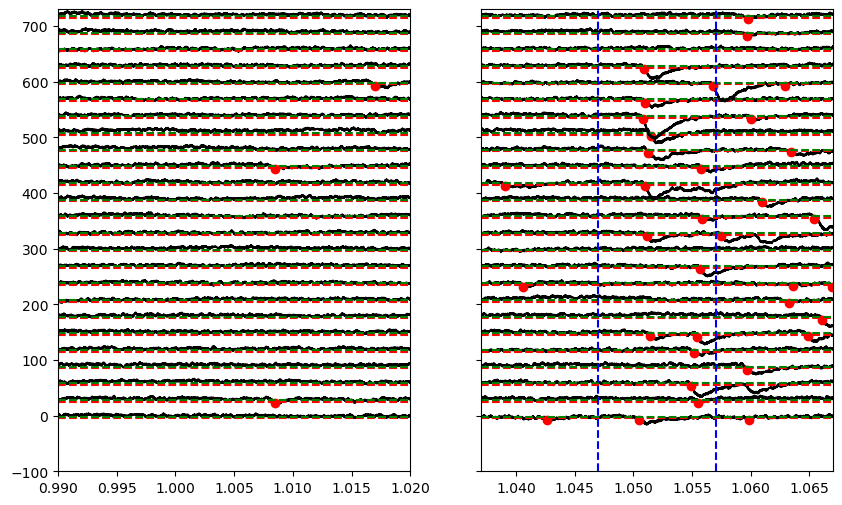

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0083.abf


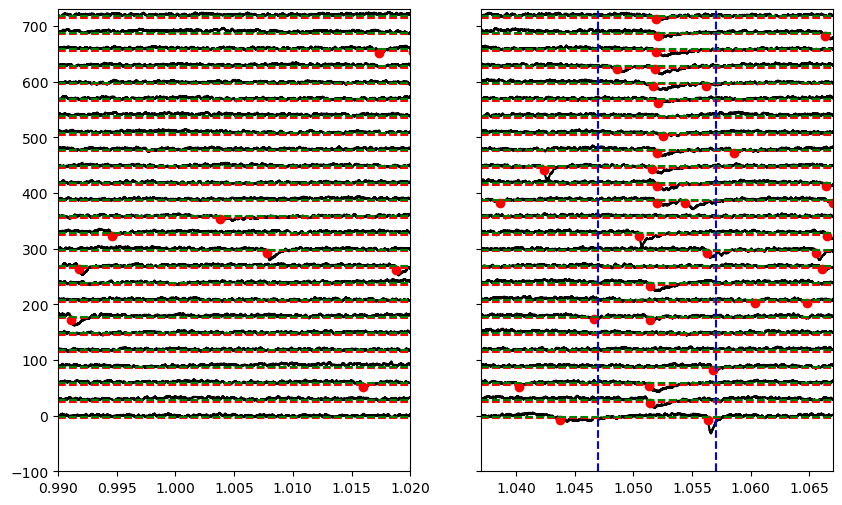

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_06_0087.abf


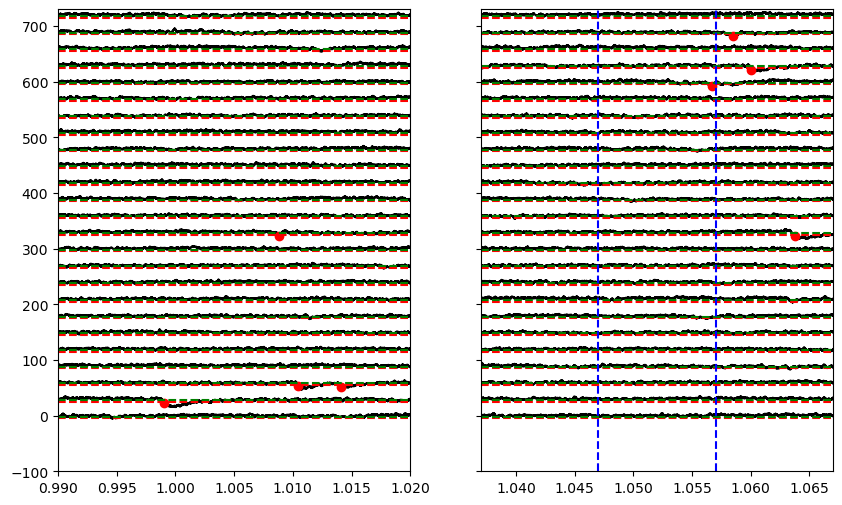

!!!! File not found: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\nan.abf !!!!
!!!! File not found: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\nan.abf !!!!
Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25806009.abf


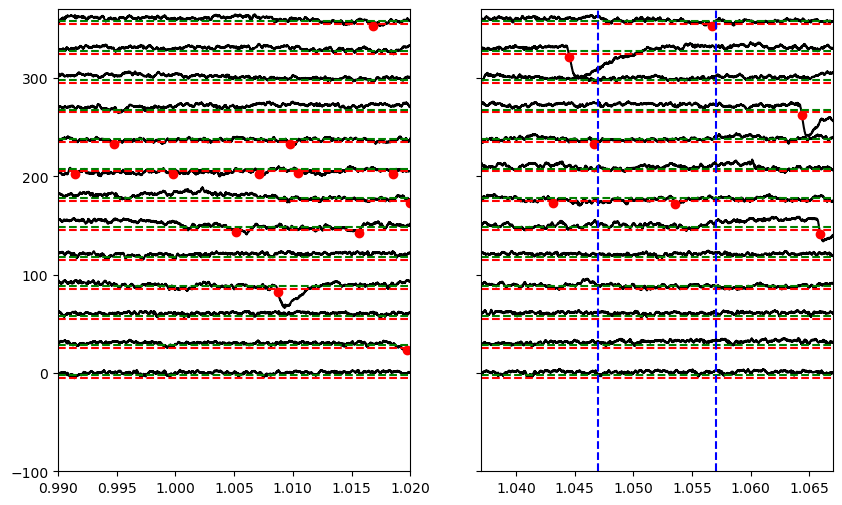

!!!! File not found: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\nan.abf !!!!
Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25806019.abf


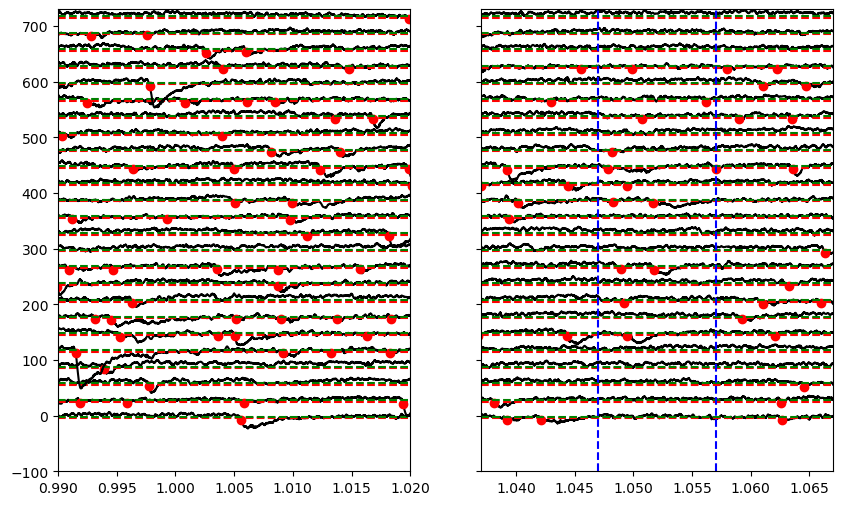

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25806028.abf


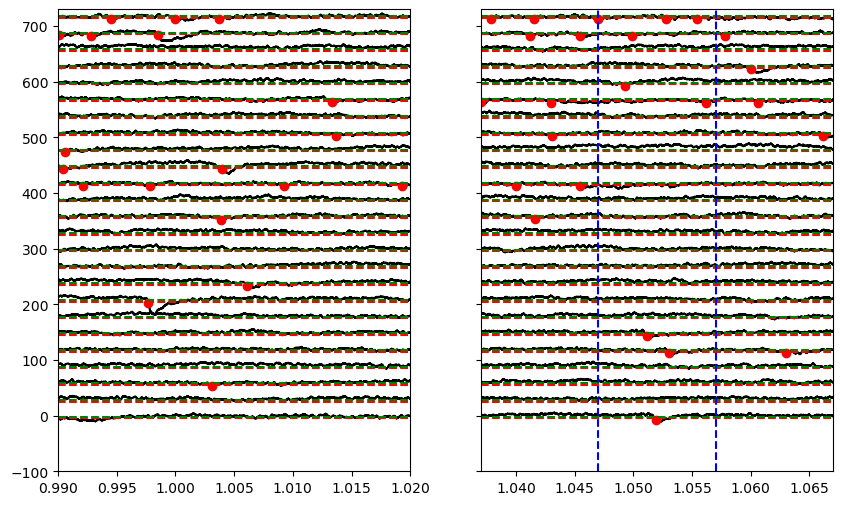

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25806033.abf


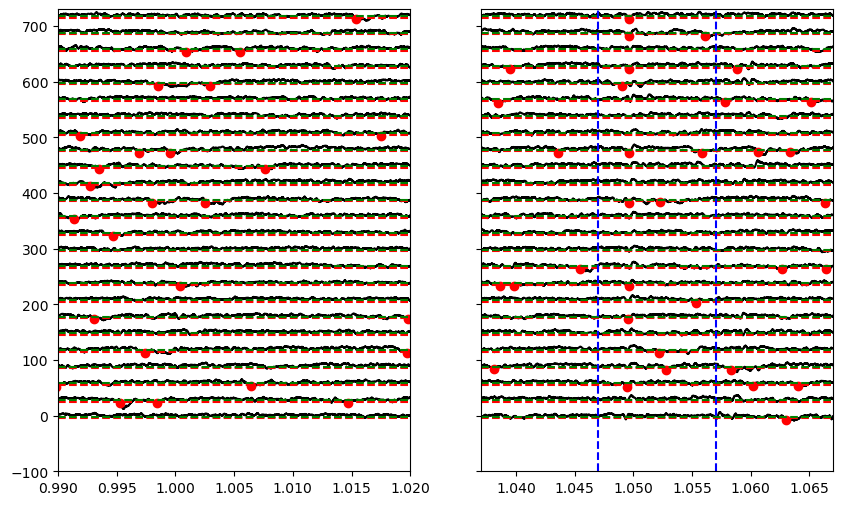

!!!! File not found: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\nan.abf !!!!
!!!! File not found: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\nan.abf !!!!
!!!! File not found: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\nan.abf !!!!
Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0014.abf


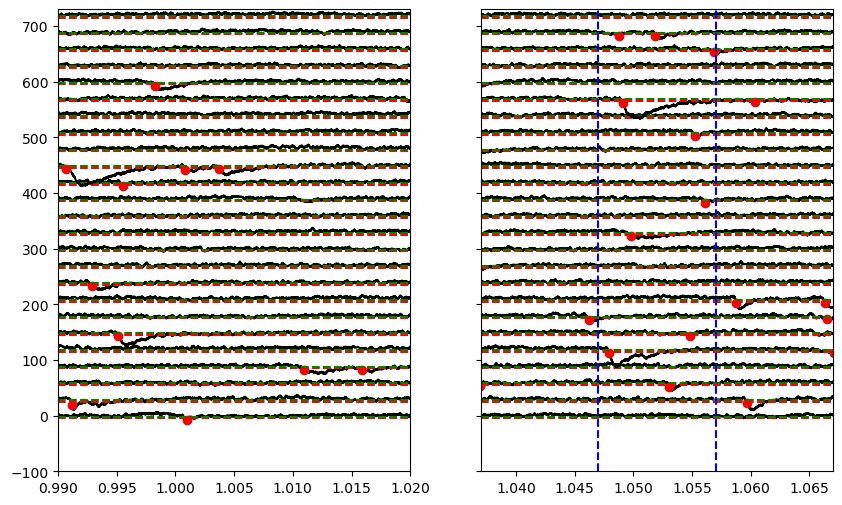

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0018.abf


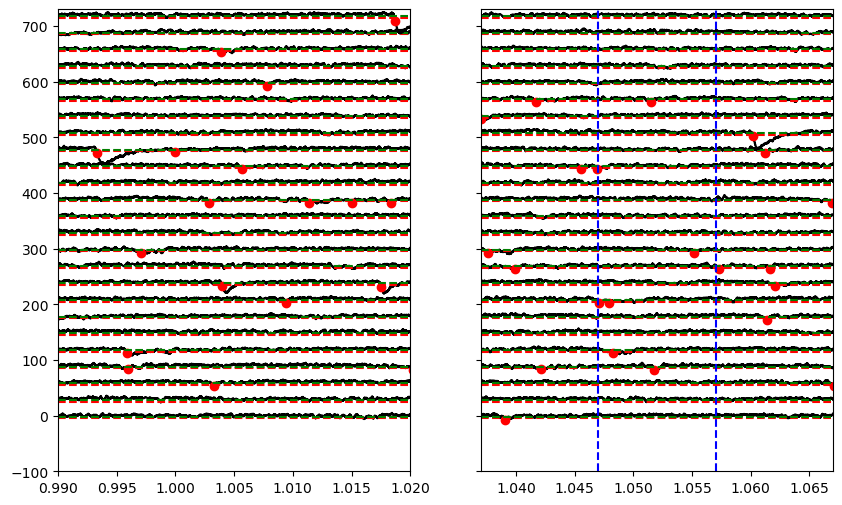

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0021.abf


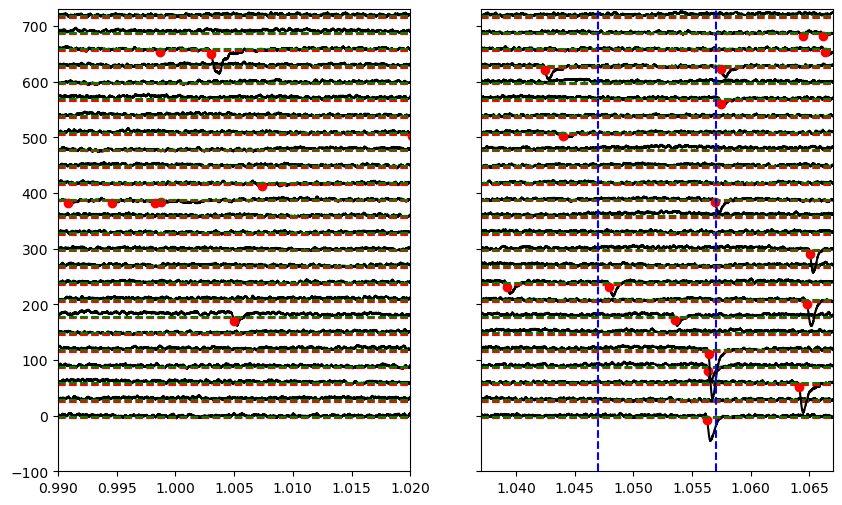

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0026.abf


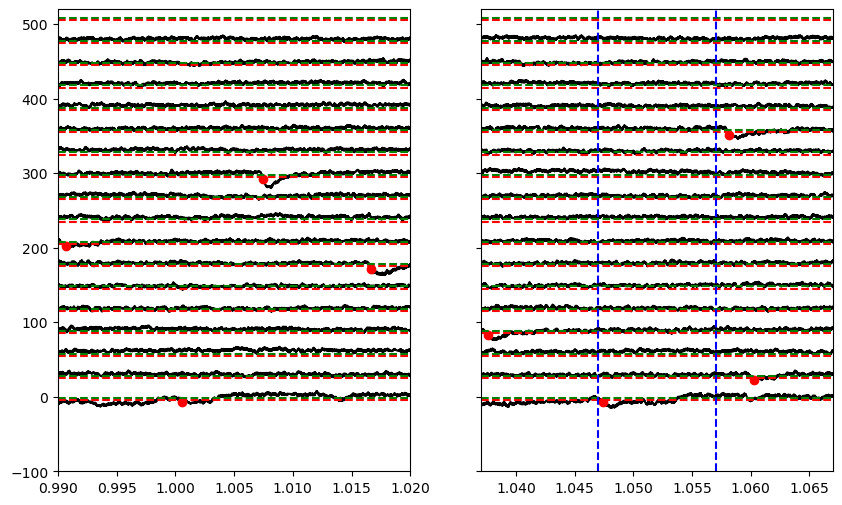

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0029.abf


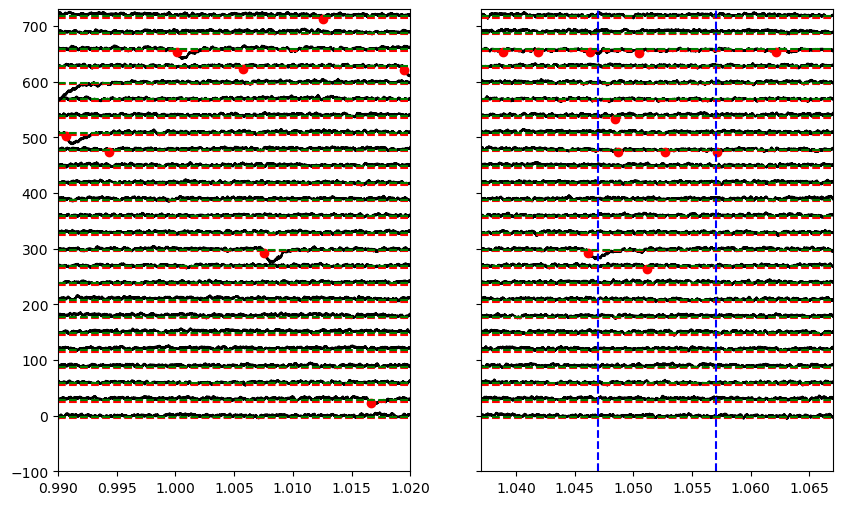

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0044.abf


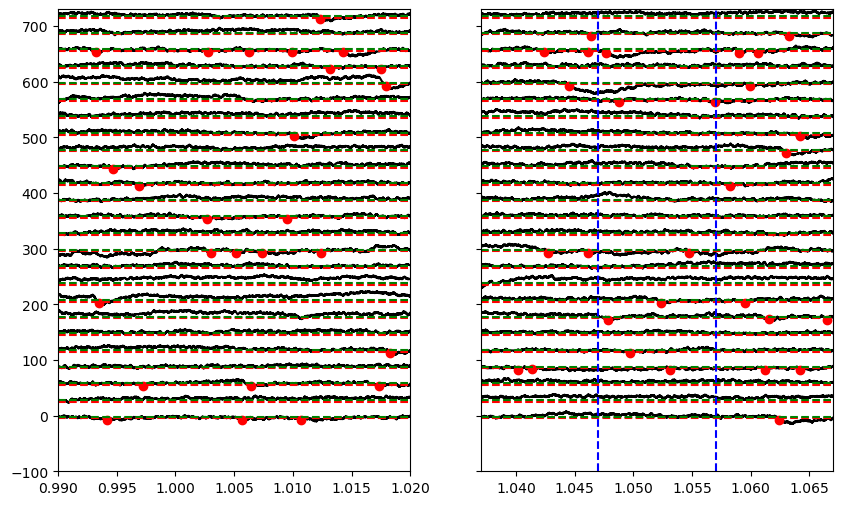

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0047.abf


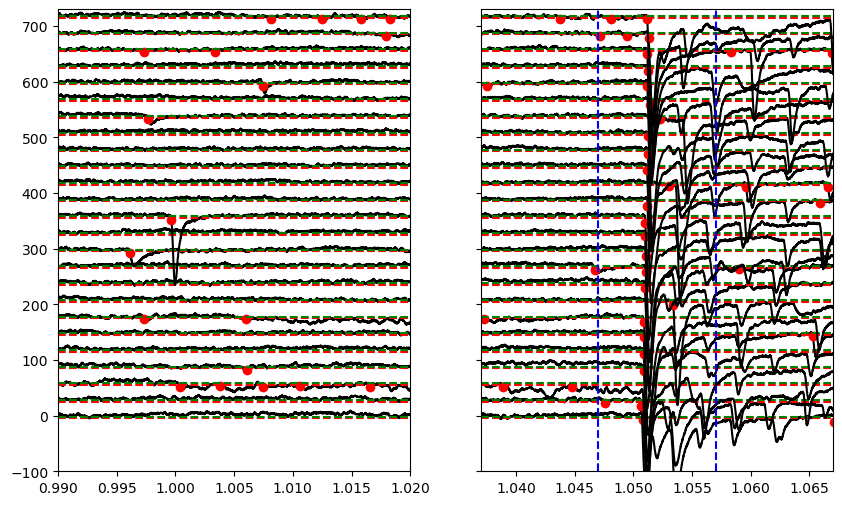

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0050.abf


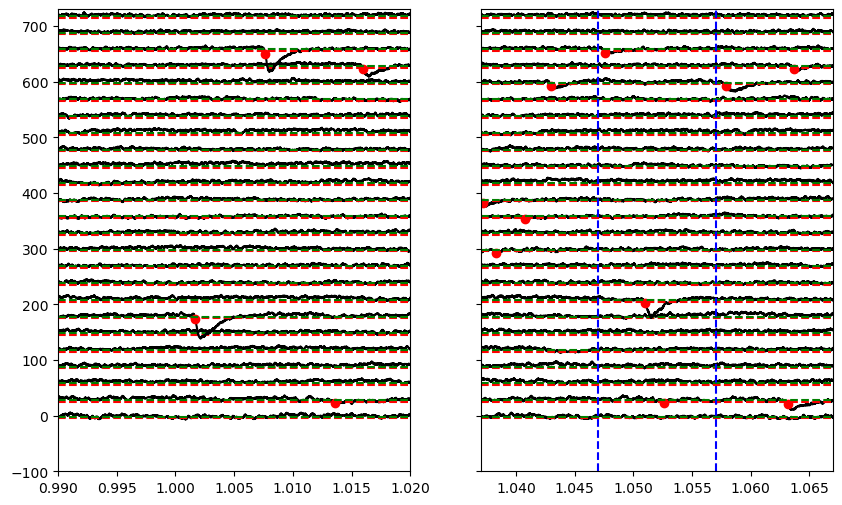

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0059.abf


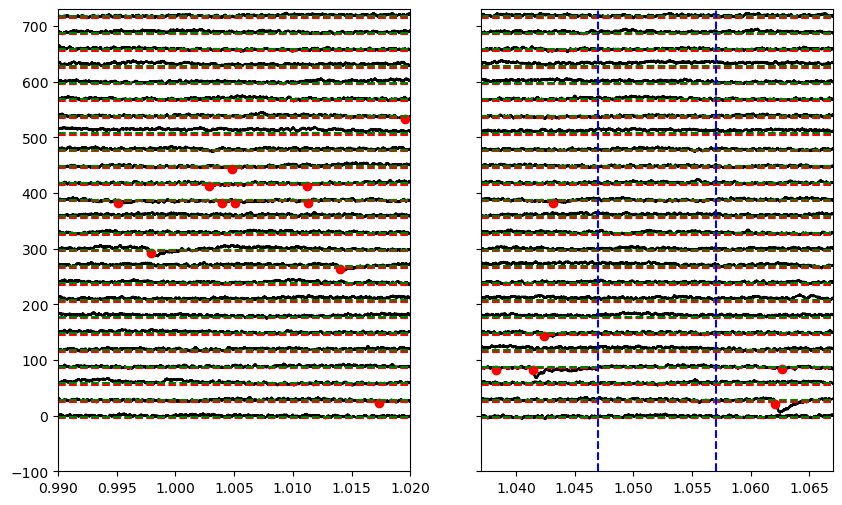

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0062.abf


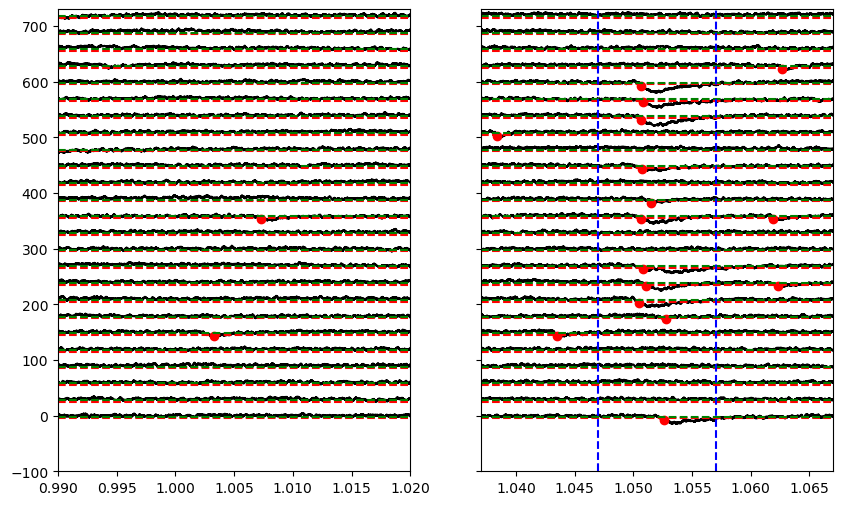

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0066.abf


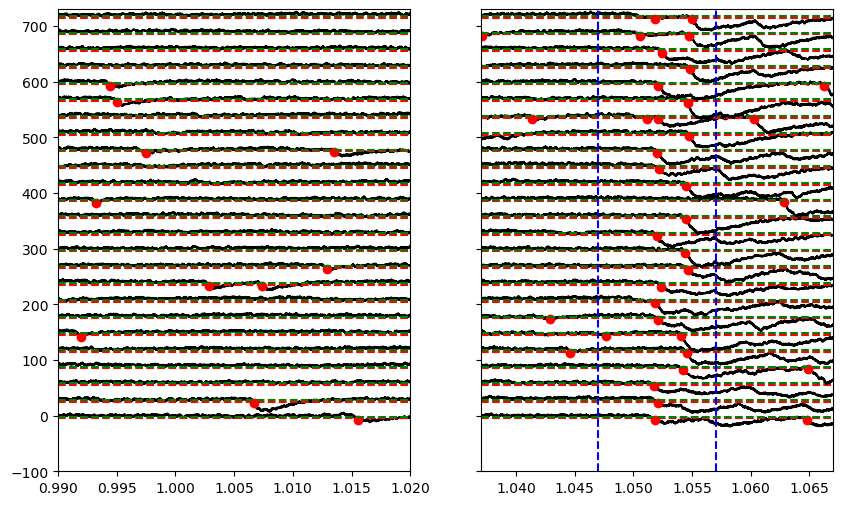

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0070.abf


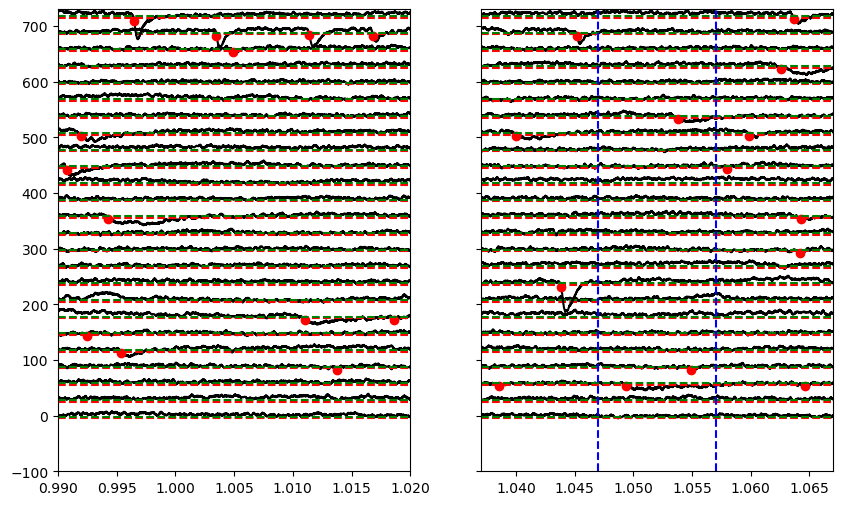

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0073.abf


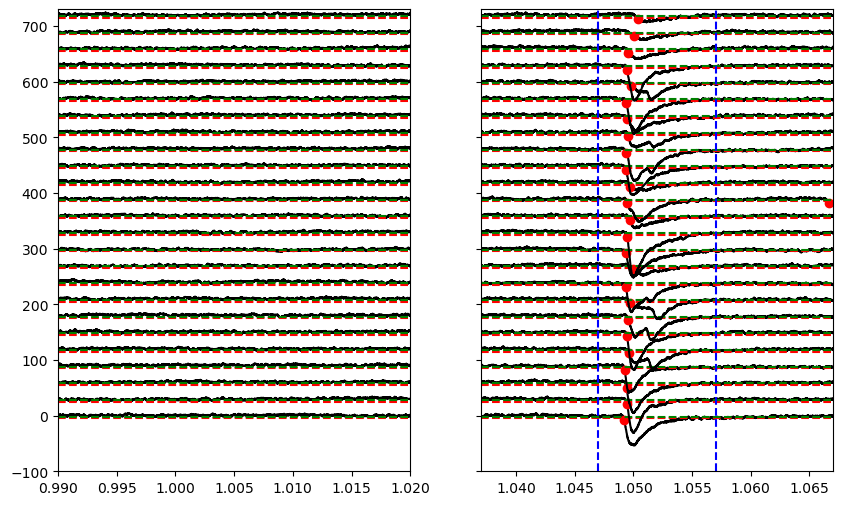

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0077.abf


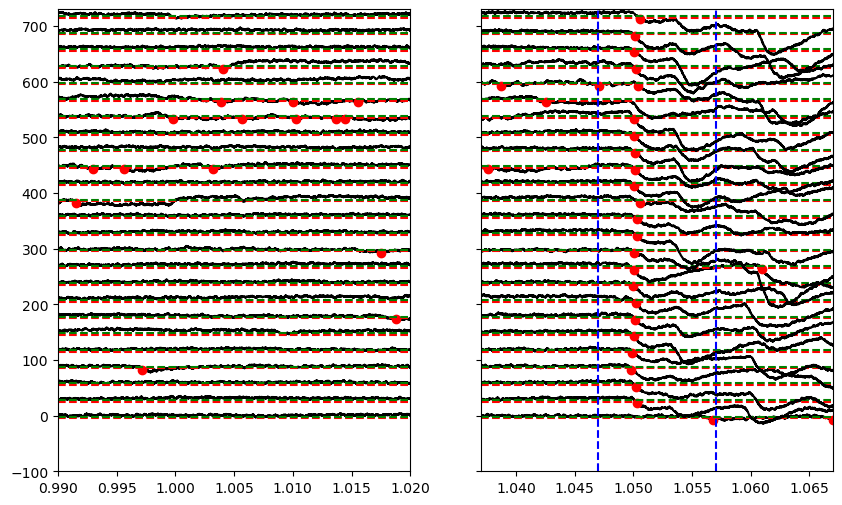

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\2025_08_07_0080.abf


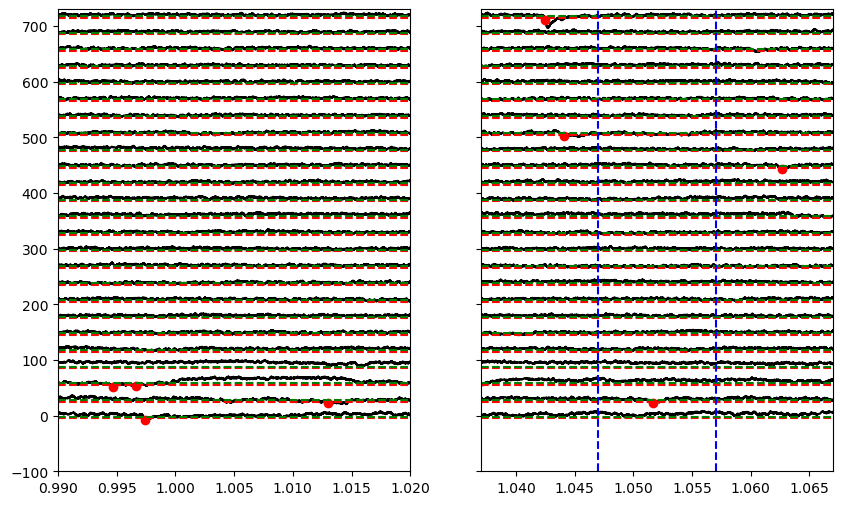

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807015.abf


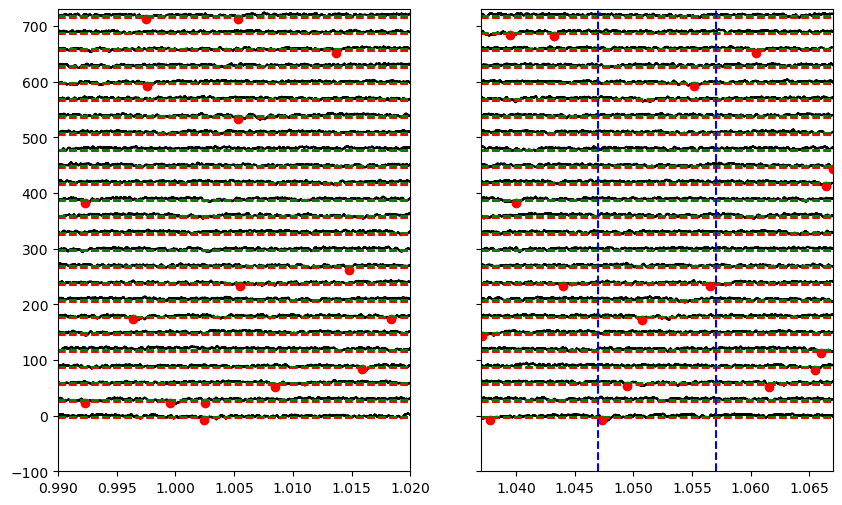

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807019.abf


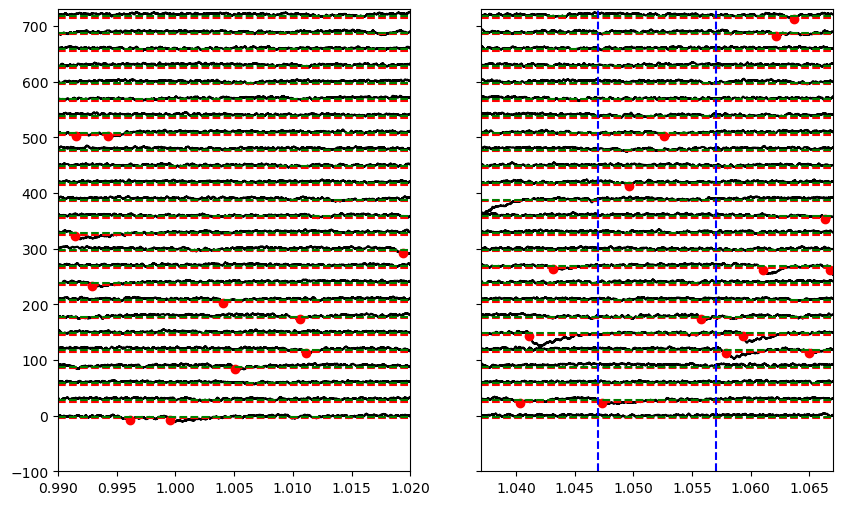

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807022.abf


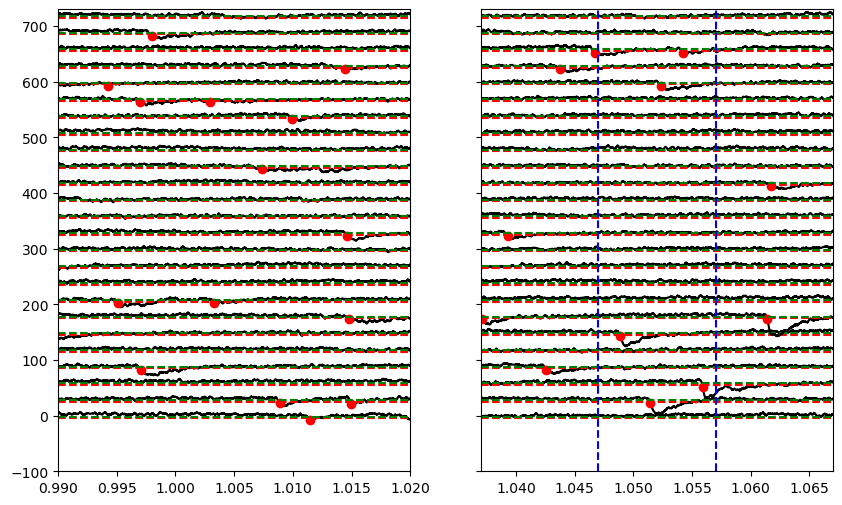

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807027.abf


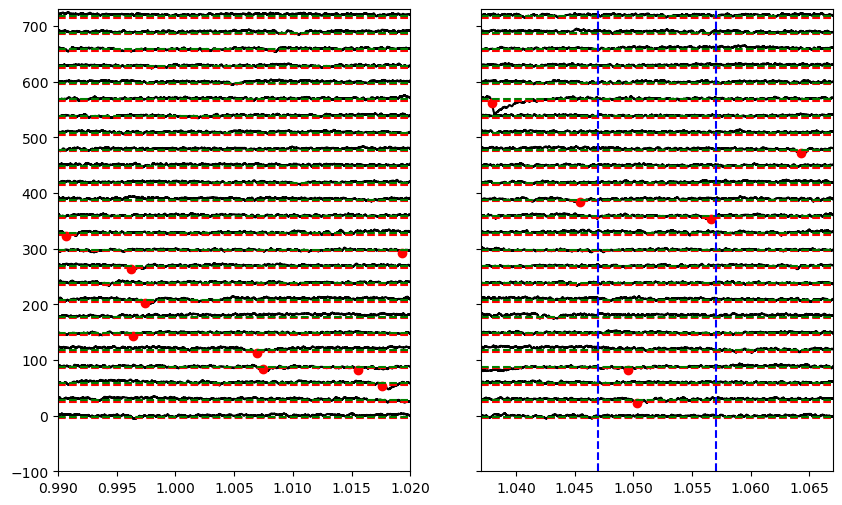

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807031.abf


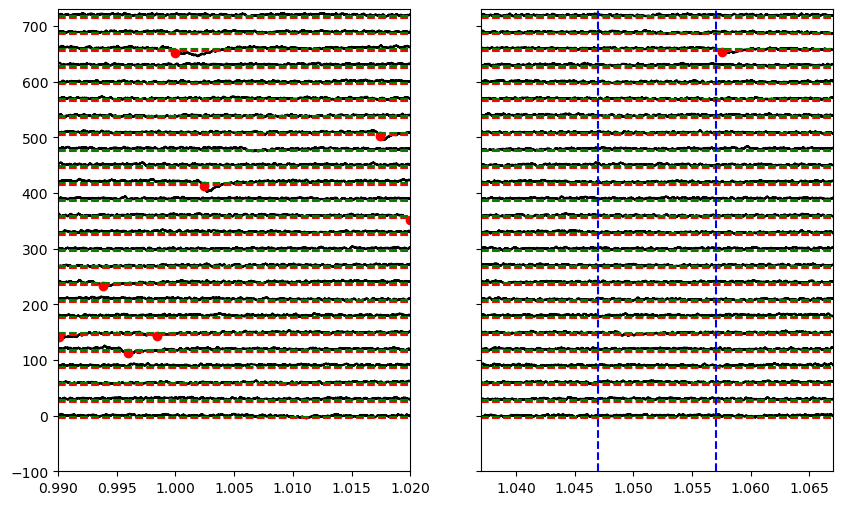

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807045.abf


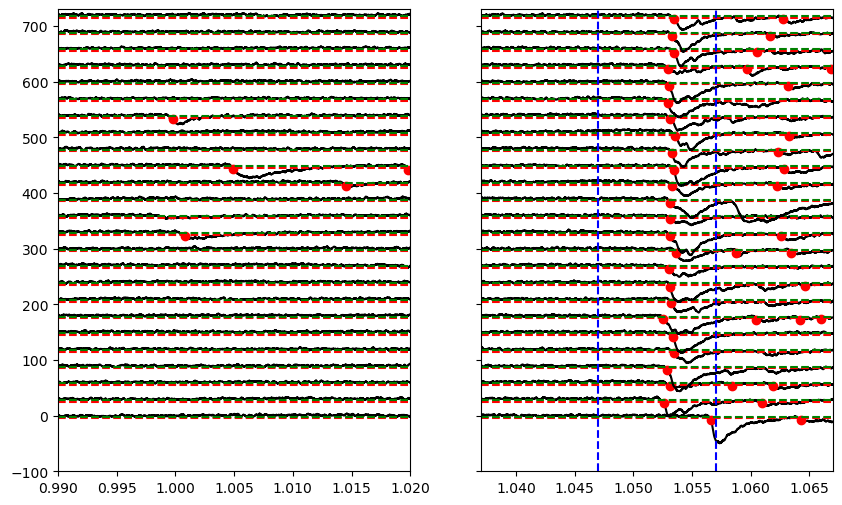

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807049.abf


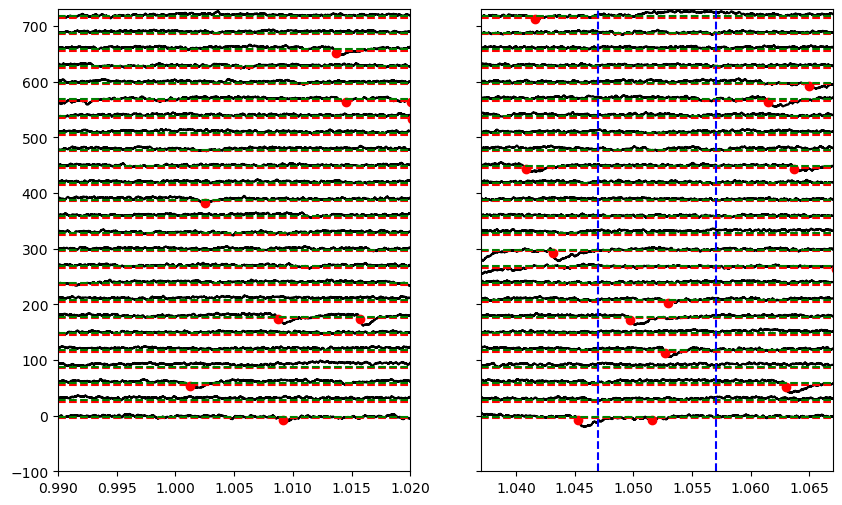

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807057.abf


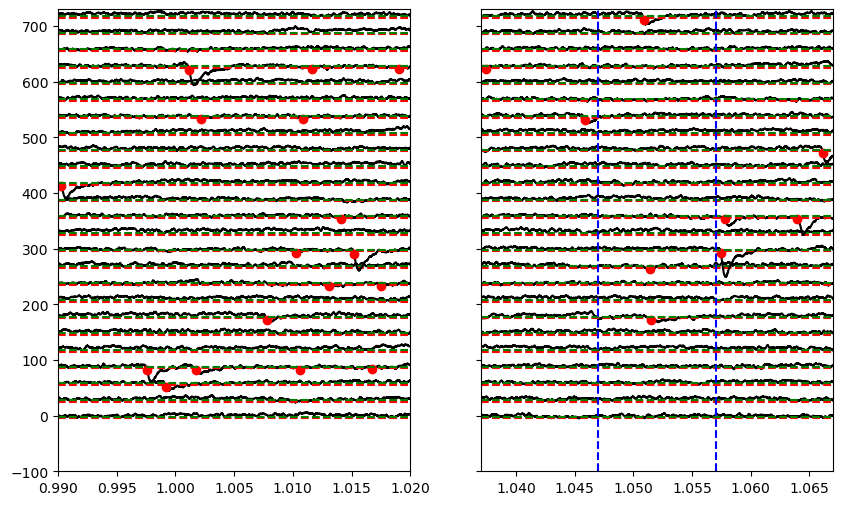

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807062.abf


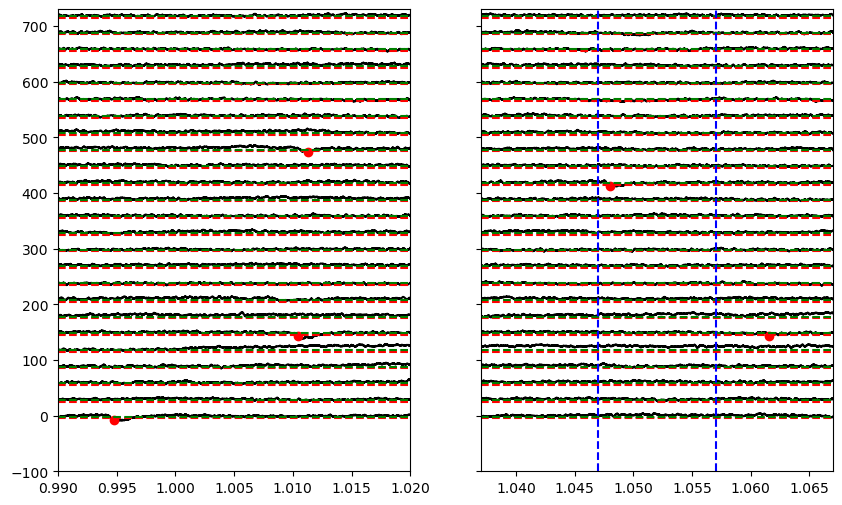

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807068.abf


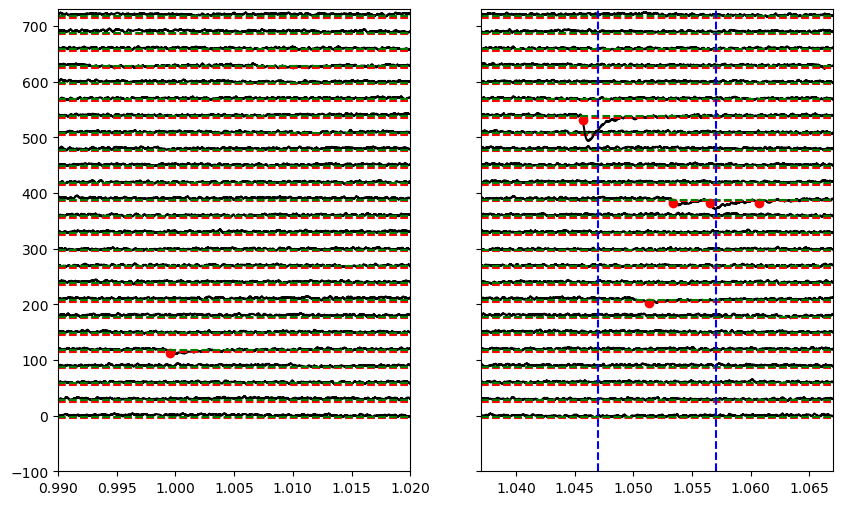

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807074.abf


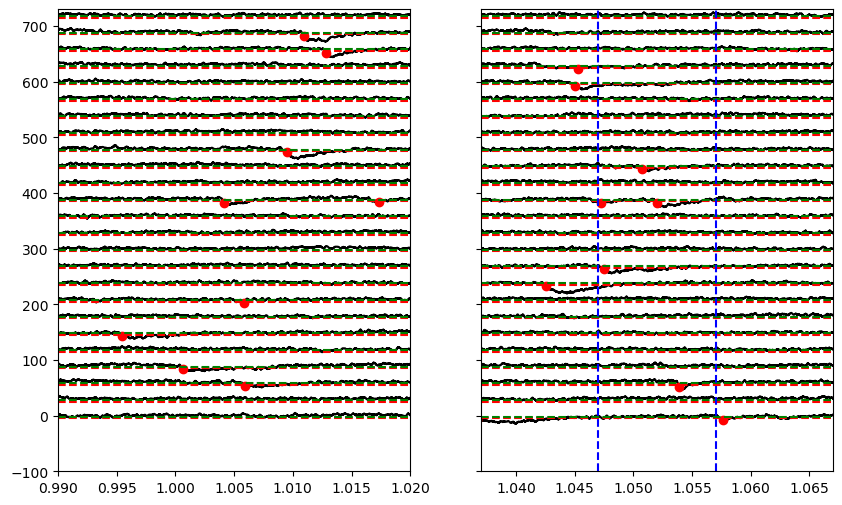

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807078.abf


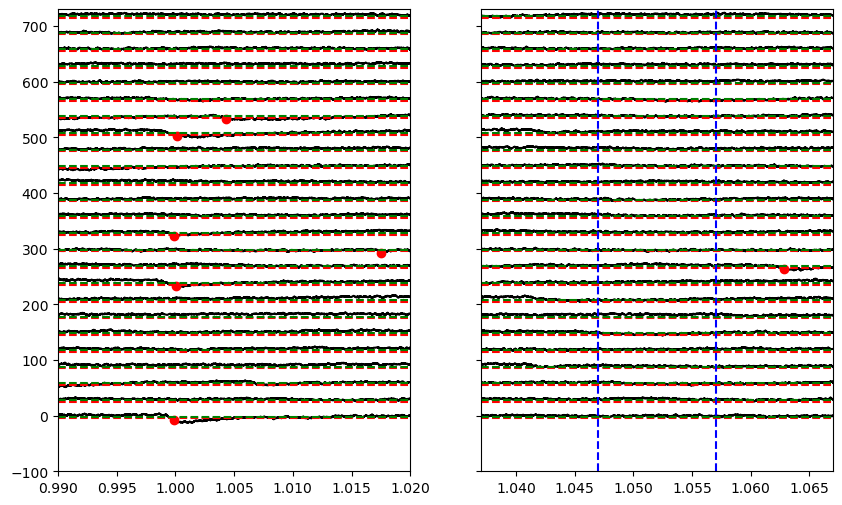

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807082.abf


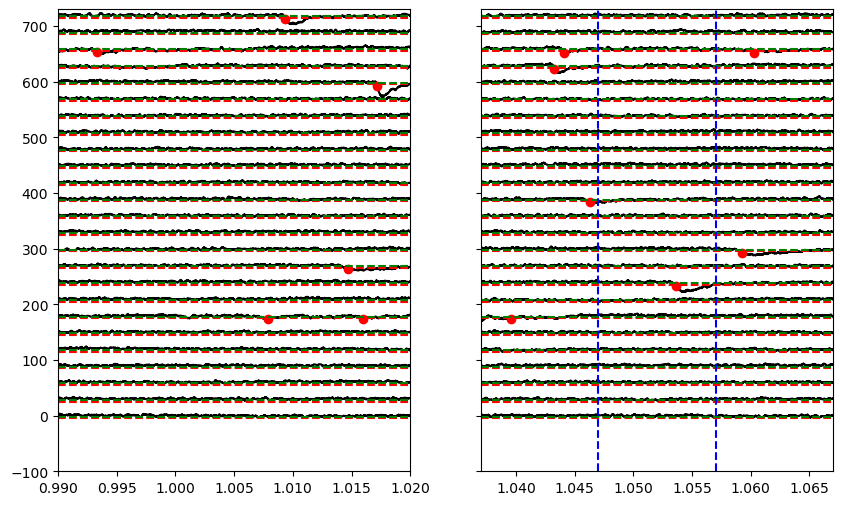

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807088.abf


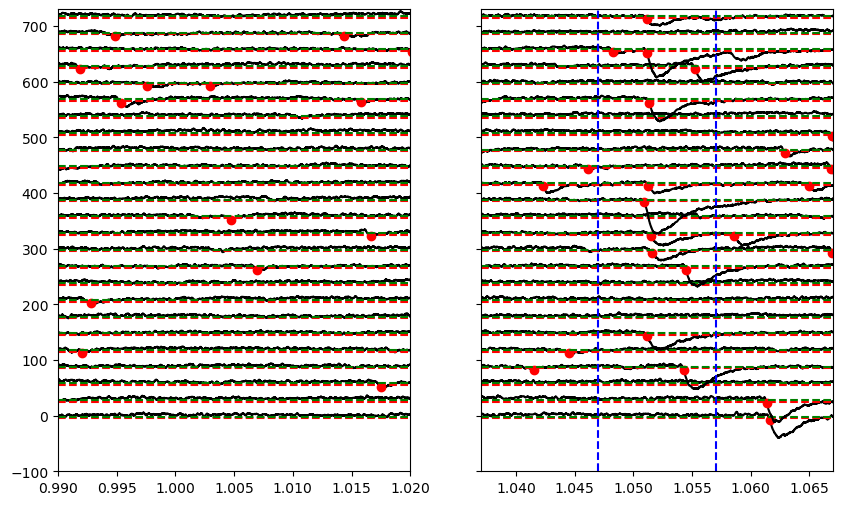

Processing file: Z:\Molsrv\Julia\Data\Opto\Opto Perifornical for Grant_2025\ALL FILES\25807092.abf


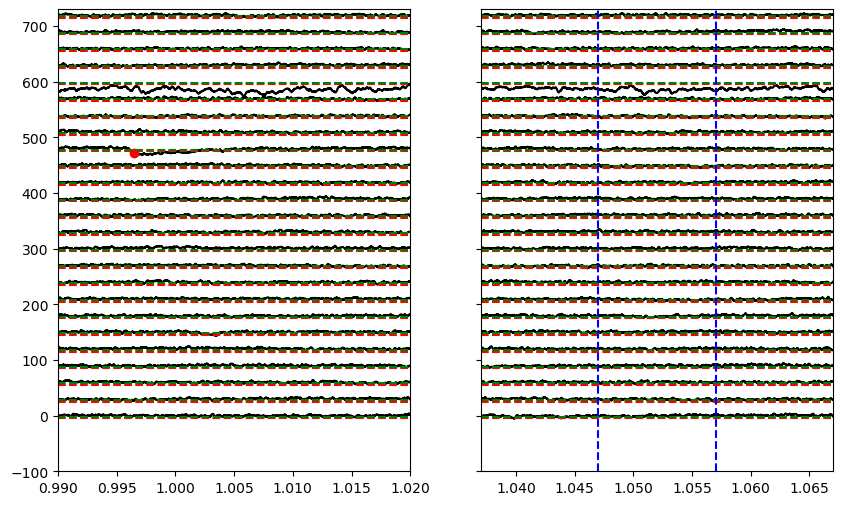

In [146]:
import glob
import pandas as pd
import os

XLSX_files = "Z:\\Molsrv\\Julia\\Data\\Opto\\Opto Perifornical for Grant_2025\\FILENAMES_Opto Perifornical_for_Yehor.xlsx"
ABF_ROOT = "Z:\\Molsrv\\Julia\\Data\\Opto\\Opto Perifornical for Grant_2025\\ALL FILES\\"
#load the Excel file
xls = pd.read_excel(XLSX_files, dtype={"PP (20 ms)": str})
#drop rows where the column "Postsynaptic" is labelled as "PS"
xls = xls[xls['Postsynaptic'] != "PS"]

print(xls.head())
pp_files = xls['PP (20 ms)'].tolist()
result_dict = {}
for file in pp_files:
    file_path = ABF_ROOT + str(file) + ".abf"
    if os.path.exists(file_path):
        print(f"Processing file: {file_path}")
        results = process_file(file_path)
        plt.savefig(ABF_ROOT+"plots/"+str(file)+".png")
        plt.close('all')
        result_dict[file] = results
    else:
        print(f"!!!! File not found: {file_path} !!!!")
    # 
    # print(f"Results for {file}: {results}")
